In [ ]:
#hide
!pip install torch
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [ ]:
#hide
from fastbook import *
from fastai.text.all import *
from IPython.display import display,HTML

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Text Preprocessing

In [ ]:
txt = "Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zombie.<br /><br />OK, first of all when you're going to make a film you must Decide if its a thriller or a drama! As a drama the movie is watchable. Parents are divorcing & arguing like in real life. And then we have Jake with his closet which totally ruins all the film! I expected to see a BOOGEYMAN similar movie, and instead i watched a drama with some meaningless thriller spots.<br /><br />3 out of 10 just for the well playing parents & descent dialogs. As for the shots with Jake: just ignore them."

In [ ]:
spacy = WordTokenizer()
toks = first(spacy([txt]))
print(coll_repr(toks, 30))

## " ".join(tokens)

(#154) ['Basically','there',"'s",'a','family','where','a','little','boy','(','Jake',')','thinks','there',"'s",'a','zombie','in','his','closet','&','his','parents','are','fighting','all','the','time.<br','/><br','/>This'...]


In [ ]:
first(spacy(['The U.S. dollar $1 is $1.00.']))

(#9) ['The','U.S.','dollar','$','1','is','$','1.00','.']

fastai then adds some additional functionality to the tokenization process with the `Tokenizer` class:

In [ ]:
tkn = Tokenizer(spacy)
print(coll_repr(tkn(txt), 50))

(#171) ['xxbos','xxmaj','basically','there',"'s",'a','family','where','a','little','boy','(','jake',')','thinks','there',"'s",'a','zombie','in','his','closet','&','his','parents','are','fighting','all','the','time','.','\n\n','xxmaj','this','movie','is','slower','than','a','soap','opera','…','and','suddenly',',','xxmaj','jake','decides','to','become'...]


In [ ]:
print(coll_repr(tkn('i like the movie soooooo much\n. I dont like'))) #I like USA usa

(#16) ['xxbos','i','like','the','movie','s','xxrep','6','o','much'...]


The rules are all listed below, here is the meaning of the special tokens:

- `UNK (xxunk)` is for an unknown word (one that isn't present in the current vocabulary)
- `PAD (xxpad)` is the token used for padding, if we need to regroup several texts of different lengths in a batch
- `BOS (xxbos)` represents the beginning of a text in your record
- `FLD (xxfld)` is used if you set mark_fields=True in your TokenizeProcessor to separate the different fields of texts (if your texts are loaded from several columns in a dataframe)
- `TK_MAJ (xxmaj)` is used to indicate the next word begins with a capital in the original text
- `TK_UP (xxup)` is used to indicate the next word is written in all caps in the original text
- `TK_REP (xxrep)` is used to indicate the next character is repeated n times in the original text (usage xxrep n {char})
- `TK_WREP(xxwrep)` is used to indicate the next word is repeated n times in the original text (usage xxwrep n {word})

Here is a brief summary of what each does:

- `fix_html`:: Replaces special HTML characters with a readable version (IMDb reviews have quite a few of these)
- `replace_rep`:: Replaces any character repeated three times or more with a special token for repetition (`xxrep`), the number of times it's repeated, then the character
- `replace_wrep`:: Replaces any word repeated three times or more with a special token for word repetition (`xxwrep`), the number of times it's repeated, then the word
- `spec_add_spaces`:: Adds spaces around / and #
- `rm_useless_spaces`:: Removes all repetitions of the space character
- `replace_all_caps`:: Lowercases a word written in all caps and adds a special token for all caps (`xxcap`) in front of it
- `replace_maj`:: Lowercases a capitalized word and adds a special token for capitalized (`xxmaj`) in front of it
- `lowercase`:: Lowercases all text and adds a special token at the beginning (`xxbos`) and/or the end (`xxeos`)

### Reading IMDB data and Preparing Dataframe for DataLoader 

In [ ]:
path

'/Users/koushik/Downloads/20210320_Batch86_87_DSC7240o_Lab_Sentiment_classification_ULMFiT'

In [ ]:
data = pd.read_csv('IMDB Dataset.csv', header=0)
data.shape

(50000, 2)

In [ ]:
data.head()

,review,sentiment
0,"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses main...",positive
1,"A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />The actors are extremely well chosen- Michael Sheen not only ""has got all the polari"" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams' diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. A masterful production about one of the great master's of comedy and his ...",positive
2,"I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue is witty and the characters are likable (even the well bread suspected serial killer). While some may be disappointed when they realize this is not Match Point 2: Risk Addiction, I thought it was proof that Woody Allen is still fully in control of the style many of us have grown to love.<br /><br />This was the most I'd laughed at one of Woody's comedies in years (dare I say a decade?). While I've ...",positive
3,"Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zombie.<br /><br />OK, first of all when you're going to make a film you must Decide if its a thriller or a drama! As a drama the movie is watchable. Parents are divorcing & arguing like in real life. And then we have Jake with his closet which totally ruins all the film! I expected to see a BOOGEYMAN similar movie, and instead i watched a drama with so...",negative
4,"Petter Mattei's ""Love in the Time of Money"" is a visually stunning film to watch. Mr. Mattei offers us a vivid portrait about human relations. This is a movie that seems to be telling us what money, power and success do to people in the different situations we encounter. <br /><br />This being a variation on the Arthur Schnitzler's play about the same theme, the director transfers the action to the present time New York where all these different characters meet and connect. Each one is connected in one way, or another to the next person, but no one seems to know the previous point of conta...",positive


In [ ]:
data.columns = ['text', 'label']

In [ ]:
data.head()

,text,label
0,"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses main...",positive
1,"A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />The actors are extremely well chosen- Michael Sheen not only ""has got all the polari"" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams' diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. A masterful production about one of the great master's of comedy and his ...",positive
2,"I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue is witty and the characters are likable (even the well bread suspected serial killer). While some may be disappointed when they realize this is not Match Point 2: Risk Addiction, I thought it was proof that Woody Allen is still fully in control of the style many of us have grown to love.<br /><br />This was the most I'd laughed at one of Woody's comedies in years (dare I say a decade?). While I've ...",positive
3,"Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zombie.<br /><br />OK, first of all when you're going to make a film you must Decide if its a thriller or a drama! As a drama the movie is watchable. Parents are divorcing & arguing like in real life. And then we have Jake with his closet which totally ruins all the film! I expected to see a BOOGEYMAN similar movie, and instead i watched a drama with so...",negative
4,"Petter Mattei's ""Love in the Time of Money"" is a visually stunning film to watch. Mr. Mattei offers us a vivid portrait about human relations. This is a movie that seems to be telling us what money, power and success do to people in the different situations we encounter. <br /><br />This being a variation on the Arthur Schnitzler's play about the same theme, the director transfers the action to the present time New York where all these different characters meet and connect. Each one is connected in one way, or another to the next person, but no one seems to know the previous point of conta...",positive


### Language Model Using DataBlock

fastai handles tokenization and numericalization automatically when `TextBlock` is passed to `DataBlock`. All of the arguments that can be passed to `Tokenize` and `Numericalize` can also be passed to `TextBlock`.

Here's how we use `TextBlock` to create a language model, using fastai's defaults:

In [ ]:
dls_lm = DataBlock(
    blocks=TextBlock.from_df('text', is_lm=True),
    get_x=ColReader('text'), 
    splitter=RandomSplitter(0.1)
).dataloaders(data, bs=128, seq_len=80)

/Users/koushik/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [ ]:
dls_lm.show_batch(max_n=2)

,text,text_
0,xxbos xxmaj if this awful film moved at a snails pace it would at least be xxunk grass grow would be more interesting . xxmaj it was painful to sit through and i only stayed in the theatre to see how all the cruel teens would xxunk is xxmaj brian depalma xxrep 4 ? xxbos xxmaj after reading the first 5 reviews on imdb i was very enthusiastic about this movie . xxmaj but it 's really an awful movie,"xxmaj if this awful film moved at a snails pace it would at least be xxunk grass grow would be more interesting . xxmaj it was painful to sit through and i only stayed in the theatre to see how all the cruel teens would xxunk is xxmaj brian depalma xxrep 4 ? xxbos xxmaj after reading the first 5 reviews on imdb i was very enthusiastic about this movie . xxmaj but it 's really an awful movie ,"
1,"most patronizing "" world music "" imaginable . xxmaj this is a tourist film , and a lousy one . xxmaj what really kills it is the incoherent sequences . xxmaj india , xxmaj egypt , xxmaj south xxmaj america , xxmaj africa , etc , etc . xxmaj no transitions , no visual explanation of why we 're suddenly ten thousand miles away , no ideas expressed in images . xxmaj just a bunch of footage of third -","patronizing "" world music "" imaginable . xxmaj this is a tourist film , and a lousy one . xxmaj what really kills it is the incoherent sequences . xxmaj india , xxmaj egypt , xxmaj south xxmaj america , xxmaj africa , etc , etc . xxmaj no transitions , no visual explanation of why we 're suddenly ten thousand miles away , no ideas expressed in images . xxmaj just a bunch of footage of third - xxunk"


Now that our data is ready, we can fine-tune the pretrained language model.

### Fine-Tuning the Language Model

To convert the integer word indices into activations that we can use for our neural network, we will use embeddings. Then we'll feed those embeddings into a *recurrent neural network* (RNN), using an architecture called *AWD-LSTM*. The link to the paper https://arxiv.org/abs/1708.02182 <br>

AWD-LSTM stands for **ASGD Weight Dropout LSTM**. The AWD-LSTM has been dominating the state-of-the-art language modeling. All the top research papers on word-level models incorporate AWD-LSTMs. 

As we discussed earlier, the embeddings in the pretrained model are merged with random embeddings added for words that weren't in the pretraining vocabulary. This is handled automatically inside `language_model_learner`:

In [ ]:
learn = language_model_learner(
    dls_lm, AWD_LSTM, drop_mult=0.3, 
    metrics=[accuracy]).to_fp32()

In [ ]:
learn.lr_find()

`language_model_learner` automatically calls `freeze` when using a pretrained model (which is the default), so this will only train the embeddings (the only part of the model that contains randomly initialized weights—i.e., embeddings for words that are in our IMDb vocab, but aren't in the pretrained model vocab):

In [ ]:
learn.fit_one_cycle(1, 0.014)

epoch,train_loss,valid_loss,accuracy,time
0,4.034898,3.936011,0.298542,10:00


### Saving and Loading Models

You can easily save the state of your model like so:

In [ ]:
learn.save('1epoch')

Path('models/1epoch.pth')

This will create a file in `learn.path/models/` named *1epoch.pth*. If you want to load your model in another machine after creating your `Learner` the same way, or resume training later, you can load the content of this file with:

In [ ]:
learn = learn.load('1epoch')

Once the initial training has completed, we can continue fine-tuning the model after unfreezing:

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(1, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,3.738276,3.735943,0.321660,10:44


Once this is done, we save all of our model except the final layer that converts activations to probabilities of picking each token in our vocabulary. The model not including the final layer is called the *encoder*. We can save it with `save_encoder`:

In [ ]:
learn.save_encoder('finetuned')

In [ ]:
learn.load_encoder('finetuned')

This completes the second stage of the text classification process: fine-tuning the language model. We can now use it to fine-tune a classifier using the IMDb sentiment labels.

### Text Generation

Before we move on to fine-tuning the classifier, let's quickly try something different: using our model to generate random reviews. Since it's trained to guess what the next word of the sentence is, we can use the model to write new reviews:

In [ ]:
TEXT = "Stopping by Woods on a Snowy Evening"
N_WORDS = 50
N_SENTENCES = 2
preds = [learn.predict(TEXT, N_WORDS, temperature=0.75) #Lowering temperature will make the texts less randomized.
         for _ in range(N_SENTENCES)]

In [ ]:
print("\n".join(preds))

Stopping by Woods on a Snowy Evening is pretty good . It is a very intriguing and well acted movie . When you see the hit and miss the DVD ( which i had heard about from a river in Kansas ) , you will understand it . Many great characters in
Stopping by Woods on a Snowy Evening and thinking he would buy a house for the night . And there 's a more interesting scene in the ghetto where his girlfriend ( debra Paget ) decides to hang a date with him , as he is a couple of girls . But the movie


As you can see, we add some randomness (we pick a random word based on the probabilities returned by the model) so we don't get exactly the same review twice. Our model doesn't have any programmed knowledge of the structure of a sentence or grammar rules, yet it has clearly learned a lot about English sentences: we can see it capitalizes properly (*I* is just transformed to *i* because our rules require two characters or more to consider a word as capitalized, so it's normal to see it lowercased) and is using consistent tense. The general review makes sense at first glance, and it's only if you read carefully that you can notice something is a bit off. Not bad for a model trained in a couple of hours! 

But our end goal wasn't to train a model to generate reviews, but to classify them... so let's use this model to do just that.

### Creating the Classifier DataLoaders

We're now moving from language model fine-tuning to classifier fine-tuning. To recap, a language model predicts the next word of a document, so it doesn't need any external labels. A classifier, however, predicts some external label—in the case of IMDb, it's the sentiment of a document.

This means that the structure of our `DataBlock` for NLP classification will look very familiar. It's actually nearly the same as we've seen for the many image classification datasets we've worked with:

In [ ]:
dls_clas = DataBlock(
    blocks=(TextBlock.from_df('text', vocab=dls_lm.vocab),CategoryBlock),
    get_x=ColReader('text'), 
    get_y=ColReader('label'), 
    splitter=RandomSplitter(0.1)
).dataloaders(data, bs=128, seq_len=72)

In [ ]:
dls_clas.show_batch(max_n=3)

,text,category
0,"xxbos xxmaj match 1 : xxmaj tag xxmaj team xxmaj table xxmaj match xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley vs xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley started things off with a xxmaj tag xxmaj team xxmaj table xxmaj match against xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit . xxmaj according to the rules of the match , both opponents have to go through tables in order to get the win . xxmaj benoit and xxmaj guerrero heated up early on by taking turns hammering first xxmaj spike and then xxmaj bubba xxmaj ray . a xxmaj german suplex by xxmaj benoit to xxmaj bubba took the wind out of the xxmaj dudley brother . xxmaj spike tried to help his brother , but the referee restrained him while xxmaj benoit and xxmaj guerrero",positive
1,"xxbos xxmaj by now you 've probably heard a bit about the new xxmaj disney dub of xxmaj miyazaki 's classic film , xxmaj laputa : xxmaj castle xxmaj in xxmaj the xxmaj sky . xxmaj during late summer of 1998 , xxmaj disney released "" kiki 's xxmaj delivery xxmaj service "" on video which included a preview of the xxmaj laputa dub saying it was due out in "" 1 xxrep 3 9 "" . xxmaj it 's obviously way past that year now , but the dub has been finally completed . xxmaj and it 's not "" laputa : xxmaj castle xxmaj in xxmaj the xxmaj sky "" , just "" castle xxmaj in xxmaj the xxmaj sky "" for the dub , since xxmaj laputa is not such a nice word in xxmaj spanish ( even though they use the word xxmaj laputa many times",positive
2,"xxbos xxrep 3 * xxmaj warning - this review contains "" plot spoilers , "" though nothing could "" spoil "" this movie any more than it already is . xxmaj it really xxup is that bad . xxrep 3 * \n\n xxmaj before i begin , xxmaj i 'd like to let everyone know that this definitely is one of those so - incredibly - bad - that - you - fall - over - laughing movies . xxmaj if you 're in a lighthearted mood and need a very hearty laugh , this is the movie for you . xxmaj now without further ado , my review : \n\n xxmaj this movie was found in a bargain bin at wal - mart . xxmaj that should be the first clue as to how good of a movie it is . xxmaj secondly , it stars the lame action",negative


Looking at the `DataBlock` definition, every piece is familiar from previous data blocks we've built, with two important exceptions:

- `TextBlock.from_df` no longer has the `is_lm=True` parameter.
- We pass the `vocab` we created for the language model fine-tuning.

The reason that we pass the `vocab` of the language model is to make sure we use the same correspondence of token to index. Otherwise the embeddings we learned in our fine-tuned language model won't make any sense to this model, and the fine-tuning step won't be of any use.

By passing `is_lm=False` (or not passing `is_lm` at all, since it defaults to `False`) we tell `TextBlock` that we have regular labeled data, rather than using the next tokens as labels.

In [ ]:
learn_cls = text_classifier_learner(dls_clas, AWD_LSTM, drop_mult=0.5, 
                                metrics=accuracy).to_fp32()

SuggestedLRs(lr_min=0.09120108485221863, lr_steep=0.009120108559727669)

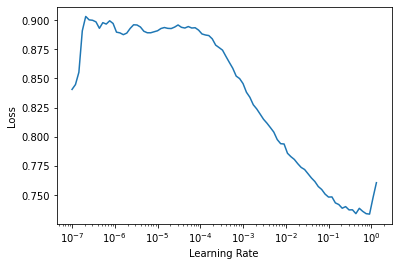

In [ ]:
learn_cls.lr_find()

The final step prior to training the classifier is to load the encoder from our fine-tuned language model. We use `load_encoder` instead of `load` because we only have pretrained weights available for the encoder; `load` by default raises an exception if an incomplete model is loaded:

In [ ]:
learn_cls = learn_cls.load_encoder('finetuned')

### Fine-Tuning the Classifier

The last step is to train with discriminative learning rates and *gradual unfreezing*. For NLP classifiers, we find that unfreezing a few layers at a time makes a real difference:

In [ ]:
learn_cls.fit_one_cycle(1, 0.009)

epoch,train_loss,valid_loss,accuracy,time
0,0.358101,0.205374,0.921800,01:18


We can pass `-2` to `freeze_to` to freeze all except the last two parameter groups:

In [ ]:
learn_cls.freeze_to(-2)
learn_cls.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,0.248828,0.185424,0.930400,01:26


Then we can unfreeze a bit more, and continue training:

In [ ]:
learn_cls.freeze_to(-3)
learn_cls.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.191089,0.156836,0.941200,01:57


And finally, the whole model!

In [ ]:
learn_cls.unfreeze()
learn_cls.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.162609,0.159636,0.942600,02:32
1,0.149697,0.151581,0.945000,02:32


We reached 94.5% accuracy, which was state-of-the-art performance just three years ago. By training another model on all the texts read backwards and averaging the predictions of those two models, we can even get to 95.1% accuracy, which was the state of the art introduced by the ULMFiT paper.

### Saving the entire model as pkl file

In [ ]:
learn_cls.export(fname=path/'imdb.pkl')

In [ ]:
loaded_model = load_learner(path/'imdb.pkl',cpu=False) # if model needs to be run on cpu make sure cpu=True

In [ ]:
loaded_model.model     # loaded_model contains both encoder and pooling linear classifier

SequentialRNN(
  (0): SentenceEncoder(
    (module): AWD_LSTM(
      (encoder): Embedding(52072, 400, padding_idx=1)
      (encoder_dp): EmbeddingDropout(
        (emb): Embedding(52072, 400, padding_idx=1)
      )
      (rnns): ModuleList(
        (0): WeightDropout(
          (module): LSTM(400, 1152, batch_first=True)
        )
        (1): WeightDropout(
          (module): LSTM(1152, 1152, batch_first=True)
        )
        (2): WeightDropout(
          (module): LSTM(1152, 400, batch_first=True)
        )
      )
      (input_dp): RNNDropout()
      (hidden_dps): ModuleList(
        (0): RNNDropout()
        (1): RNNDropout()
        (2): RNNDropout()
      )
    )
  )
  (1): PoolingLinearClassifier(
    (layers): Sequential(
      (0): LinBnDrop(
        (0): BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): Dropout(p=0.2, inplace=False)
        (2): Linear(in_features=1200, out_features=50, bias=False)
        (3): ReLU(inplace=True

### Predictions

In [ ]:
learn_cls.show_results()

,text,category,category_
0,"xxbos ( some spoilers included : ) \n\n xxmaj although , many commentators have called this film surreal , the term fits poorly here . xxmaj to quote from xxmaj encyclopedia xxmaj britannica 's , surreal means : \n\n "" fantastic or incongruous imagery "" : xxmaj one need n't explain to the unimaginative how many ways a plucky ten - year - old boy at large and seeking his fortune in the driver 's seat of a red xxmaj mustang could be fantastic : those curious might read xxmaj james xxmaj kincaid ; but if you asked said lad how he were incongruous behind the wheel of a sports car , he 'd surely protest , "" no way ! "" xxmaj what fantasies and incongruities the film offers mostly appear within the first fifteen minutes . xxmaj thereafter we get more iterations of the same , in an",positive,negative
1,"xxbos xxmaj titanic directed by xxmaj james xxmaj cameron presents a fictional love story on the historical setting of the xxmaj titanic . xxmaj the plot is simple , xxunk , or not for those who love plots that twist and turn and keep you in suspense . xxmaj the end of the movie can be figured out within minutes of the start of the film , but the love story is an interesting one , however . xxmaj kate xxmaj winslett is wonderful as xxmaj rose , an aristocratic young lady betrothed by xxmaj cal ( billy xxmaj zane ) . xxmaj early on the voyage xxmaj rose meets xxmaj jack ( leonardo dicaprio ) , a lower class artist on his way to xxmaj america after winning his ticket aboard xxmaj titanic in a poker game . xxmaj if he wants something , he goes and gets it",positive,positive
2,"xxbos xxmaj here are the matches . . . ( adv . = advantage ) \n\n xxmaj the xxmaj warriors ( ultimate xxmaj warrior , xxmaj texas xxmaj tornado and xxmaj legion of xxmaj doom ) v xxmaj the xxmaj perfect xxmaj team ( mr xxmaj perfect , xxmaj ax , xxmaj smash and xxmaj crush of xxmaj demolition ) : xxmaj ax is the first to go in seconds when xxmaj warrior splashes him for the pin ( 4 - 3 adv . xxmaj warriors ) . i knew xxmaj ax was n't a healthy man but if he was that unhealthy why bother have him on the card ? xxmaj this would be his last xxup ppv . xxmaj eventually , both xxmaj legion of xxmaj doom and xxmaj demolition job out cheaply via double disqualification ( 2 - 1 adv . xxmaj warriors ) . xxmaj perfect",negative,negative
3,"xxbos xxmaj wrestlemania 6 , is an entertaining xxmaj wrestlemania , if not an entirely successful one . xxmaj the xxmaj ultimate xxmaj challenge , is of course worth the price of admission alone , but once again as with a lot of the early xxmaj mania 's , there 's too much filler in between . xxmaj the crowd pops for almost everything , and as always , giving us the reliable announcing team of xxunk xxmaj body . xxmaj having a xxmaj face vs xxmaj face match as the main event for a xxmaj wrestlemania , was absolutely unheard of at this time , it only made things that much more tense . \n\n xxmaj matches . \n\n xxmaj koko xxup b. xxmaj ware / w xxmaj frankie xxmaj vs "" the xxmaj model "" xxmaj rick xxmaj martel . xxmaj for a 3 or so minute match",positive,positive
4,"xxbos xxmaj the freedom of having your own xxmaj sea xxmaj going xxmaj power xxmaj boat , the excitement of going on underwater adventures a rugged , an 's man of an adventurer and xxunk so well endowed ! ) assistants in fine xxmaj bikinis were all definite selling points for "" sea xxup xxunk - 61 ) . \n\n xxmaj just what was the reason for producing a sort of sea going "" gun for hire "" * series . xxmaj let 's look closely now . xxmaj there must be a some clues around . \n\n xxmaj if we were to look back just a little , we see the xxup rko xxmaj radio xxmaj pictures production of xxup underwater ! ( 1955 ) . xxmaj it starred xxmaj jane xxmaj russell , xxmaj gilbert xxmaj roland , xxmaj richard xxmaj egan and xxmaj lori xxmaj nelson as",positive,positive
5,"xxbos xxmaj that word ' true ' in this film 's title got my alarm bells ringing . xxmaj 

In [ ]:
loaded_model.predict('I like the movie a lot. However I am disappointed with little role for Scarlett Johansson.')

('positive', tensor(1), tensor([0.1367, 0.8633]))